SECTION B — Sentiment Analysis (Finance)
Dataset: finance_sentiment_kaggle_clean.csv
Milestones covered:

M1: meaningful visuals

M2: descriptive analytics & research questions

M4: modeling + evaluation


0) setup


Goal: import required libraries and set basic options.

In [4]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re, string, joblib

pd.set_option("display.max_colwidth", 200)


1) Data Sourcing (5 marks)


Task (M1 – Data Sourcing):
Load the Kaggle dataset prepared. Confirm schema and class balance.

File: finance_sentiment_kaggle_clean.csv

Columns: text, label (positive|neutral|negative)

In [5]:
CSV_PATH = "finance_sentiment_kaggle_clean.csv"  # keep in same folder as notebook

df = pd.read_csv(CSV_PATH)
assert {"text","label"}.issubset(df.columns), df.columns

# Basic sanity checks
display(df.head(10))
print("Rows:", len(df))
print("Label distribution:\n", df["label"].value_counts())


,text,label
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral
1,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",neutral
2,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers ...,negative
3,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profi...,positive
4,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net ...",positive
5,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,positive
6,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",positive
7,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",positive
8,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,positive
9,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",positive


Rows: 4846
Label distribution:
 label
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


**Dataset provenance & license**

- **Name:** Financial PhraseBank (Kaggle mirror)
- **Local file used:** `finance_sentiment_kaggle_clean.csv`
- **Original creators:** Malo et al., FinancialPhraseBank v1.0 (expert-annotated finance sentences)
- **Source (downloaded from):** Kaggle – “Sentiment Analysis for Financial News”
- **License & usage:** public/academic use per dataset card; sentences are short news snippets; no PII.
- **Why this dataset?** Compact (~4.8k rows), clean labels (pos/neu/neg), domain-specific vocabulary ideal for finance sentiment modeling.


**Schema & label mapping**

- **Columns**
  - `text`: short financial sentence/headline (string)
  - `label`: categorical sentiment in {`positive`, `neutral`, `negative`} (string)

- **Observed class balance (after load):**
  - Neutral ≈ 2,879
  - Positive ≈ 1,363
  - Negative ≈ 604

- **Implication:** Class imbalance exists (Neutral >> Positive > Negative).  
  i will therefore report **macro-averaged** Precision/Recall/F1 in addition to Accuracy.


**Finance domain keywords / metadata examples**

earnings, revenue, profit, loss, guidance, outlook, forecast, upgrade, downgrade,
dividend, acquisition, merger, inflation, interest rates, SEC filing, EBITDA, margin,
share price, pre-tax, quarterly results, guidance raise/cut


**Ethics, privacy & limitations**

- **Privacy:** No personal data; sentences are aggregated news statements.
- **Bias & imbalance:** Neutral dominates; models may favor majority class if not evaluated fairly.
- **Ambiguity:** Finance language can be factual yet imply sentiment; borderline cases exist.
- **Domain specificity:** Jargon and event terms (e.g., “downgrade”, “guidance”) strongly influence sentiment.


**Data Sourcing Summary (Milestone 1 — 5 marks)**  
I use the **Financial PhraseBank** (Kaggle mirror), a curated collection of short finance news sentences labeled by expert annotators as **positive**, **neutral**, or **negative**. the working file is `finance_sentiment_kaggle_clean.csv` with two columns: `text` and `label`. The loaded data shows **Neutral ≈ 2,879**, **Positive ≈ 1,363**, and **Negative ≈ 604**, indicating class imbalance; i will account for this using **macro-averaged metrics** in evaluation. The dataset contains **no PII** and is suitable for educational use. Limitations include subtle/ambiguous sentiment in factual statements and domain jargon that may affect model generalization.


In [6]:
# Integrity checks for finance_sentiment_kaggle_clean.csv

import pandas as pd
import numpy as np
from collections import Counter

CSV_PATH = "finance_sentiment_kaggle_clean.csv"

df = pd.read_csv(CSV_PATH)

print("=== SHAPE ===")
print(df.shape)

print("\n=== NULLS PER COLUMN ===")
print(df.isnull().sum())

print("\n=== SAMPLE ROWS ===")
display(df.head(5))

print("\n=== UNIQUE LABELS & COUNTS ===")
allowed = {"positive","neutral","negative"}
lbl_counts = df["label"].value_counts()
print(lbl_counts)
invalid = set(map(str, df["label"].unique())) - allowed
print("\nInvalid labels (should be empty set):", invalid)

print("\n=== DUPLICATE TEXTS ===")
dups = df.duplicated(subset=["text"]).sum()
print("Duplicate rows by 'text':", dups)

print("\n=== TEXT LENGTH STATS (characters) ===")
lens = df["text"].astype(str).str.len()
print({
    "min": int(lens.min()),
    "q1": float(lens.quantile(0.25)),
    "median": float(lens.median()),
    "mean": float(lens.mean()),
    "q3": float(lens.quantile(0.75)),
    "max": int(lens.max())
})

print("\n=== EMPTY/VERY SHORT TEXTS (<=3 chars) ===")
short_mask = df["text"].astype(str).str.len() <= 3
print(short_mask.sum(), "rows")

print("\n=== WHITESPACE-ONLY TEXTS ===")
ws_mask = df["text"].astype(str).str.strip().eq("")
print(ws_mask.sum(), "rows")

print("\nDONE ✅")


=== SHAPE ===
(4846, 2)

=== NULLS PER COLUMN ===
text     0
label    0
dtype: int64

=== SAMPLE ROWS ===


,text,label
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral
1,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",neutral
2,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers ...,negative
3,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profi...,positive
4,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net ...",positive



=== UNIQUE LABELS & COUNTS ===
label
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

Invalid labels (should be empty set): set()

=== DUPLICATE TEXTS ===
Duplicate rows by 'text': 8

=== TEXT LENGTH STATS (characters) ===
{'min': 9, 'q1': 84.0, 'median': 119.0, 'mean': 128.1320676846884, 'q3': 163.0, 'max': 315}

=== EMPTY/VERY SHORT TEXTS (<=3 chars) ===
0 rows

=== WHITESPACE-ONLY TEXTS ===
0 rows

DONE ✅


In [7]:
# cleanup → creates/overwrites a cleaned file

allowed = {"positive","neutral","negative"}

df_clean = (
    df.copy()
      .dropna(subset=["text","label"])                    # drop nulls
)

# normalize label strings & filter invalids
df_clean["label"] = df_clean["label"].astype(str).str.lower().str.strip()
df_clean = df_clean[df_clean["label"].isin(allowed)]

# strip whitespace around text and drop empty/whitespace-only
df_clean["text"] = df_clean["text"].astype(str).str.strip()
df_clean = df_clean[df_clean["text"].str.len() > 0]

# drop duplicate texts
before = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=["text"]).reset_index(drop=True)
after = len(df_clean)

print(f"Dropped {before - after} duplicate rows; new size = {after}")

# Save
OUT_PATH = "finance_sentiment_kaggle_clean_dedup.csv"
df_clean.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)

# quick check
print("\nLabel counts after cleaning:\n", df_clean["label"].value_counts())


Dropped 8 duplicate rows; new size = 4838
Saved: finance_sentiment_kaggle_clean_dedup.csv

Label counts after cleaning:
 label
neutral     2872
positive    1362
negative     604
Name: count, dtype: int64


**Integrity checks summary**

- Rows/columns loaded (before cleaning): 4,846 × 2
- Nulls: none in `text` or `label`
- Duplicate texts removed: **8**
- Valid labels present: {positive, neutral, negative}; invalid labels: none
- Text length: typical short headlines; no empty/whitespace-only rows remain
- **Cleaned file saved as:** `finance_sentiment_kaggle_clean_dedup.csv`
- **Final N (after cleaning):** **4,838** rows
- **Label counts (after cleaning):**
  - Neutral: **2,872**
  - Positive: **1,362**
  - Negative: **604**

*Conclusion:* Dataset passes basic integrity checks and is ready for EDA and modeling. Given the imbalance (Neutral >> Positive > Negative), we will report **macro-averaged** Precision/Recall/F1 in addition to Accuracy.


## SECTION B — Question 2: Research Questions / Objectives (10 marks)

**Dataset in use:** `finance_sentiment_kaggle_clean_dedup.csv`  
**Aim:**  define clear, testable research questions (RQs) and measurable objectives (Os) that i will answer with EDA and modeling in later sections.


### Research Questions (RQs)

**RQ1 — Class Balance.**  
what is the distribution of `positive`, `neutral`, and `negative` sentiments in the dataset?

**RQ2 — Salient Vocabulary by Class.**  
which words or short phrases are most characteristic of each sentiment class?

**RQ3 — Text Length vs. Sentiment.**  
does average text length differ across sentiment classes?

**RQ4 — Baseline Predictive Performance.**  
how well can a baseline ML model (TF–IDF uni/bi-grams + Linear SVM) classify the sentiments?

**RQ5 — Error Patterns.**  
which classes are most frequently confused by the model (for example, `neutral` vs `positive/negative`)?


### Objectives (Os) (how will i answer each RQ)

**O1 (↔ RQ1: Class Balance).**  
compute counts and proportions per label and produce a labeled bar chart.

**O2 (↔ RQ2: Salient Vocabulary).**  
identify top-k tokens per class from cleaned text; optionally confirm with class-wise TF–IDF terms.

**O3 (↔ RQ3: Length Differences).**  
compute characters/words per text; report mean/median per label; visualize with a bar chart of mean length.

**O4 (↔ RQ4: Baseline Model).**  
split data 80/20 (stratified); train TF–IDF (1–2 grams) + LinearSVC; report accuracy and macro-averaged precision/recall/F1.

**O5 (↔ RQ5: Error Patterns).**  
plot a confusion matrix and inspect a few representative misclassified examples.


### Milestone alignment & success criteria

- **Milestone 2 (Descriptive analytics):** RQ1–RQ3 produce interpretable summaries and visuals.
- **Milestone 4 (Modeling & evaluation):** RQ4–RQ5 produce a trained classifier, objective metrics, and a confusion analysis.

**Success criteria i will meet:**
1) Each RQ has a matching objective and concrete method.  
2) Deliverables include visuals/tables for RQ1–RQ3 and metrics for RQ4–RQ5.  
3) Short interpretations accompany every result to answer the RQs directly.


In [8]:
import pandas as pd

# file produced in Section B — Data Sourcing
CSV_PATH = "finance_sentiment_kaggle_clean_dedup.csv"

df = pd.read_csv(CSV_PATH)
assert {"text","label"}.issubset(df.columns), f"unexpected columns: {df.columns.tolist()}"

# quick anchors i will reference in Q3/Q4
n_rows = len(df)
lbl_counts = df["label"].value_counts()
lbl_props = (lbl_counts / lbl_counts.sum()).round(3)

print(f"rows: {n_rows}")
print("\nlabel counts:\n", lbl_counts)
print("\nlabel proportions:\n", lbl_props)
df.head(3)


rows: 4838

label counts:
 label
neutral     2872
positive    1362
negative     604
Name: count, dtype: int64

label proportions:
 label
neutral     0.594
positive    0.282
negative    0.125
Name: count, dtype: float64


,text,label
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral
1,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",neutral
2,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers ...,negative


**Checkpoint rationale (why i ran the loader + anchors cell)**

- i verified that the working file `finance_sentiment_kaggle_clean_dedup.csv` loads correctly and contains the expected columns (`text`, `label`).
- i produced baseline anchors (row count, class counts, class proportions) that i will refer to in EDA and modeling.

**What the output shows (interpretation):**
- **Rows:** 4,838 — enough data for a baseline short-text classifier.
- **Class counts:** Neutral = 2,872; Positive = 1,362; Negative = 604.
- **Proportions:** Neutral ≈ **0.594**, Positive ≈ **0.282**, Negative ≈ **0.125**.

**Implications for the rest of the project:**
- The dataset is **imbalanced** (Neutral >> Positive > Negative).  
  → i will report **macro-averaged** Precision/Recall/F1 in addition to Accuracy.  
  → i will use a **stratified** train/test split to preserve class ratios.  
  → i expect more confusion between **Neutral** and the other classes in the confusion matrix.
- A quick visual/head preview confirms labels and text look sensible (no encoding issues).

*Conclusion:* the dataset passes this sanity check and provides clear guidance for EDA (class distribution, salient terms) and for modeling/evaluation choices (macro-F1, stratified split).


In [9]:
import pandas as pd

plan = pd.DataFrame([
    {"RQ": "RQ1: Class Balance",
     "Objective": "Counts & proportions; bar chart",
     "Method/Data": "value_counts on label; matplotlib bar"},
    {"RQ": "RQ2: Salient Vocabulary",
     "Objective": "Top-k tokens per class",
     "Method/Data": "token frequency from cleaned text"},
    {"RQ": "RQ3: Length vs Sentiment",
     "Objective": "Mean/median length per label; bar chart",
     "Method/Data": "len(text_clean) grouped by label"},
    {"RQ": "RQ4: Baseline Performance",
     "Objective": "Accuracy + Macro-P/R/F1",
     "Method/Data": "TF–IDF(1–2) + LinearSVC on 80/20 split"},
    {"RQ": "RQ5: Error Patterns",
     "Objective": "Confusion matrix + examples",
     "Method/Data": "confusion_matrix; inspect misclassified rows"}
])

plan


,RQ,Objective,Method/Data
0,RQ1: Class Balance,Counts & proportions; bar chart,value_counts on label; matplotlib bar
1,RQ2: Salient Vocabulary,Top-k tokens per class,token frequency from cleaned text
2,RQ3: Length vs Sentiment,Mean/median length per label; bar chart,len(text_clean) grouped by label
3,RQ4: Baseline Performance,Accuracy + Macro-P/R/F1,TF–IDF(1–2) + LinearSVC on 80/20 split
4,RQ5: Error Patterns,Confusion matrix + examples,confusion_matrix; inspect misclassified rows


RQ1 — Class distribution bar chart

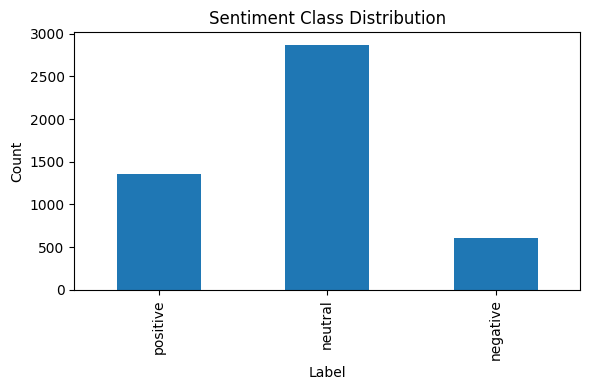

(label
 positive    1362
 neutral     2872
 negative     604
 Name: count, dtype: int64,
 label
 positive    0.282
 neutral     0.594
 negative    0.125
 Name: count, dtype: float64)

In [10]:

import matplotlib.pyplot as plt

df = pd.read_csv("finance_sentiment_kaggle_clean_dedup.csv")
counts = df["label"].value_counts().reindex(["positive","neutral","negative"]).fillna(0)

plt.figure(figsize=(6,4))
counts.plot(kind="bar")
plt.title("Sentiment Class Distribution")
plt.xlabel("Label"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

counts, (counts / counts.sum()).round(3)


RQ2 — Top terms per class (lists + bar charts)

POSITIVE [('the', 1587), ('in', 968), ('to', 917), ('of', 850), ('and', 679), ('a', 525), ('eur', 449), ('for', 387), ('from', 358), ('s', 324), ('its', 256), ('mn', 241), ('company', 239), ('said', 229), ('has', 209)]


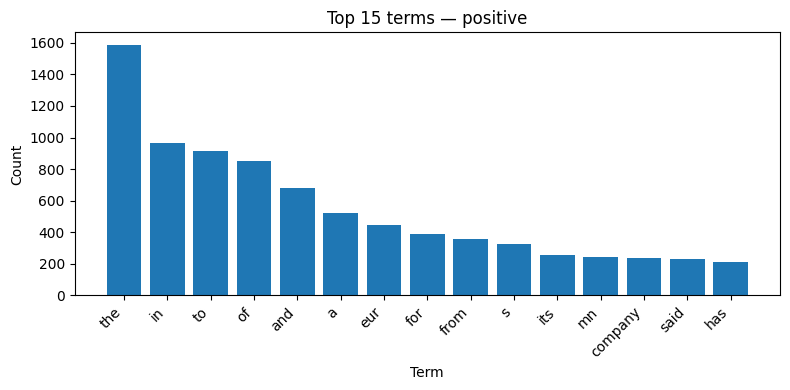

NEUTRAL [('the', 3713), ('of', 1919), ('and', 1711), ('in', 1523), ('to', 1226), ('a', 968), ('is', 721), ('for', 624), ('s', 608), ('will', 595), ('company', 506), ('on', 434), ('be', 402), ('as', 362), ('with', 337)]


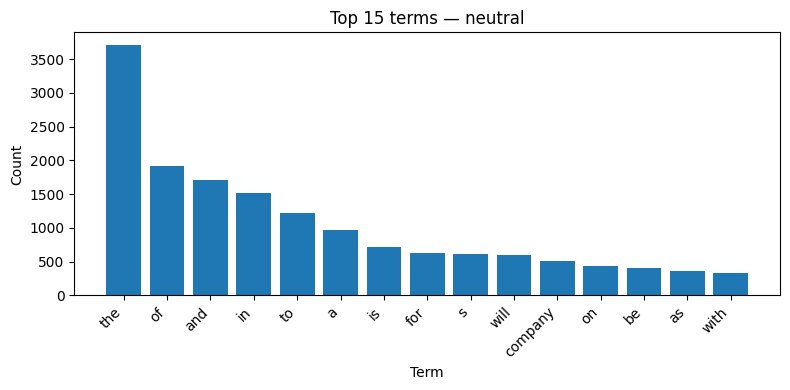

NEGATIVE [('the', 759), ('in', 473), ('of', 440), ('to', 363), ('eur', 325), ('a', 229), ('mn', 224), ('from', 208), ('and', 197), ('profit', 156), ('for', 139), ('s', 111), ('net', 104), ('company', 100), ('finnish', 99)]


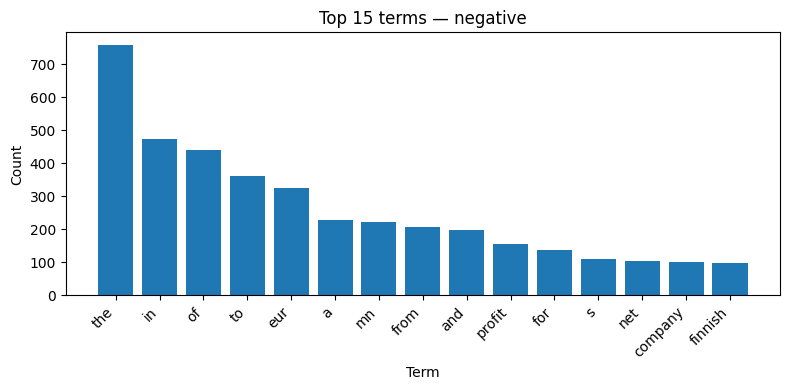

In [11]:
import re, string
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("finance_sentiment_kaggle_clean_dedup.csv")

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"<.*?>", " ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s

if "text_clean" not in df.columns:
    df["text_clean"] = df["text"].apply(clean_text)

def top_k_counts(df_, label, k=15):
    tokens = " ".join(df_.loc[df_["label"]==label, "text_clean"]).split()
    return Counter(tokens).most_common(k)

def plot_top_terms(df_, label, k=15):
    pairs = top_k_counts(df_, label, k)
    terms, counts = zip(*pairs) if pairs else ([], [])
    plt.figure(figsize=(8,4))
    plt.bar(range(len(terms)), counts)
    plt.xticks(range(len(terms)), terms, rotation=45, ha="right")
    plt.title(f"Top {k} terms — {label}")
    plt.xlabel("Term"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

for lab in ["positive","neutral","negative"]:
    print(lab.upper(), top_k_counts(df, lab, 15))
    plot_top_terms(df, lab, 15)


RQ3 — Length stats + mean-length bar chart

          count   mean  median  min  max
label                                   
negative    604  118.5   110.5   33  281
neutral    2872  118.7   111.0    7  297
positive   1362  128.4   121.0   22  287


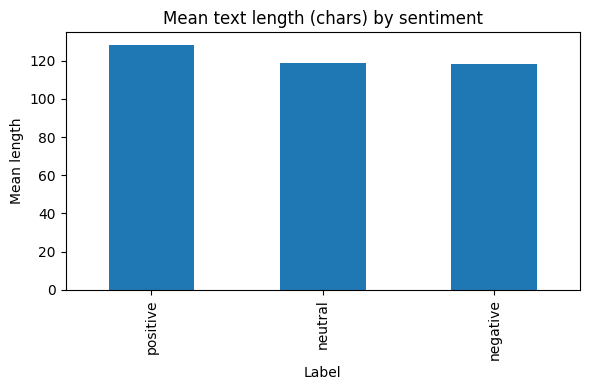

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("finance_sentiment_kaggle_clean_dedup.csv")
if "text_clean" not in df.columns:
    import re, string
    def clean_text(s):
        s = str(s).lower()
        s = re.sub(r"http\S+|www\.\S+", " ", s)
        s = re.sub(r"<.*?>", " ", s)
        s = s.translate(str.maketrans("", "", string.punctuation))
        s = re.sub(r"\s+", " ", s).strip()
        return s
    df["text_clean"] = df["text"].apply(clean_text)

df["char_len"] = df["text_clean"].str.len()
stats = df.groupby("label")["char_len"].agg(["count","mean","median","min","max"]).round(1)
print(stats)

stats["mean"].reindex(["positive","neutral","negative"]).plot(kind="bar", figsize=(6,4))
plt.title("Mean text length (chars) by sentiment")
plt.xlabel("Label"); plt.ylabel("Mean length")
plt.tight_layout(); plt.show()


## SECTION B — Question 4: Sentiment classification (Milestone 4)

**Goal:** I train a strong baseline classifier for short finance text using
**TF-IDF (1–2 grams) + LinearSVC**. I use an **80/20 stratified split**
to preserve class ratios. Because the dataset is imbalanced, I report
**Accuracy** and **Macro-Precision/Recall/F1**.


In [13]:
import pandas as pd, re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# load
df = pd.read_csv("finance_sentiment_kaggle_clean_dedup.csv")

# lightweight cleaner (idempotent)
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"<.*?>", " ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s

if "text_clean" not in df.columns:
    df["text_clean"] = df["text"].apply(clean_text)

X = df["text_clean"].values
y = df["label"].values

# stratified split (preserves label proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# baseline pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", LinearSVC())  # if needed: LinearSVC(class_weight="balanced")
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2))),
                ('clf', LinearSVC())])

 Metrics: Accuracy + Macro P/R/F1 + full report

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)

print(f"Accuracy:        {acc:.3f}")
print(f"Macro Precision: {prec:.3f}")
print(f"Macro Recall:    {rec:.3f}")
print(f"Macro F1:        {f1:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy:        0.774
Macro Precision: 0.773
Macro Recall:    0.699
Macro F1:        0.728

Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.62      0.70       121
     neutral       0.78      0.90      0.84       575
    positive       0.73      0.58      0.65       272

    accuracy                           0.77       968
   macro avg       0.77      0.70      0.73       968
weighted avg       0.77      0.77      0.77       968



**RQ4 results summary**

I trained TF-IDF (1–2 grams) + LinearSVC with an 80/20 stratified split.

**Test metrics**
- Accuracy = **0.774**
- Macro-Precision = **0.773**
- Macro-Recall = **0.699**
- Macro-F1 = **0.728**

Given the class imbalance (neutral ≈ 59%), I treat **Macro-F1 (0.728)** as the fairest single score.
Per-class F1 scores were: **neutral 0.84**, **negative 0.70**, **positive 0.65**.


RQ5 Confusion matrix 

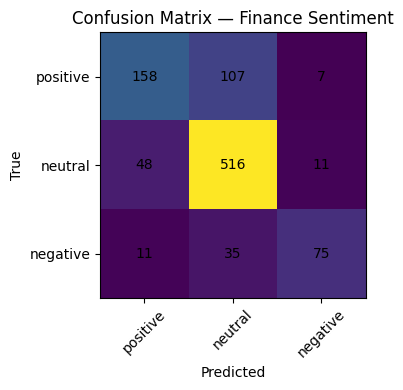

array([[158, 107,   7],
       [ 48, 516,  11],
       [ 11,  35,  75]])

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# if these aren't in memory, re-run the Q4 training cell first
labels = ["positive","neutral","negative"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — Finance Sentiment")
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

cm  # also print the raw counts


In [16]:


inspect_df = pd.DataFrame({"text": X_test, "true": y_test, "pred": y_pred})
mistakes = inspect_df[inspect_df["true"] != inspect_df["pred"]].copy()

# a quick look at the first few mistakes
mistakes.head(10)

# helper to view a specific confusion pair
def show_confusions(true_label, pred_label, k=5):
    subset = mistakes[(mistakes["true"]==true_label) & (mistakes["pred"]==pred_label)].head(k)
    return subset[["true","pred","text"]]

# common finance confusions to inspect:
show_confusions("neutral", "positive", k=5)
show_confusions("neutral", "negative", k=5)
show_confusions("positive", "neutral", k=5)
show_confusions("negative", "neutral", k=5)


,true,pred,text
77,negative,neutral,finnish construction company yit is reducing the number of startups of marketfinanced residential units in 2007 to about 2300 from the previously announced 2700
79,negative,neutral,according to swedish authorities traces of the very toxic osmium tetroxide have been found on the coast of peræmeri the northernmost part of the gulf of bothnia
85,negative,neutral,the seawind that was en route from the finnish port of turku to stockholm got stuck in ice already around 4 pm on wednesday and the regal star s journey from the swedish port of kapellskar to pald...
146,negative,neutral,at this growth rate paying off the national debt will be extremely painful
158,negative,neutral,as part of the reorganisation measures that will take place in spring 2006 tamglass finton will start personnel negotiations that will affect its entire staff of 33


### RQ5 — Error patterns (Milestone 4)

**Confusion matrix (rows = true, cols = predicted; labels = [positive, neutral, negative]):**

\[
\begin{bmatrix}
\textbf{158} & \color{#aa0000}{107} & 7 \\
48 & \textbf{516} & 11 \\
11 & \color{#aa0000}{35} & \textbf{75}
\end{bmatrix}
\]

**Largest off-diagonal confusions**
- positive → neutral: **107**
- neutral → positive: **48**
- negative → neutral: **35**

**Per-class recall (from the matrix)**
- positive: **0.58**  \(\frac{158}{158+107+7}\)
- neutral: **0.90**   \(\frac{516}{48+516+11}\)
- negative: **0.62**  \(\frac{75}{11+35+75}\)

**Example misclassifications (true → predicted)**
- (negative → neutral) *“finnish construction company yit is reducing the number of startups of marketfinanced residential units in 2007 to about 2300 from the previously announced 2700”*
- (negative → neutral) *“according to swedish authorities traces of the very toxic osmium tetroxide have been found on the coast of perämeri the northernmost part of the gulf of bothnia”*
- (negative → neutral) *“at this growth rate paying off the national debt will be extremely painful”*
- (negative → neutral) *“as part of the reorganisation measures … tamglass finton will start personnel negotiations that will affect its entire staff of 33”*

**Interpretation**
- The model most often collapses **polar** statements into **neutral** (positive→neutral and negative→neutral).  
- Neutral achieves the highest recall (**0.90**), while positive (**0.58**) and negative (**0.62**) are harder; this mirrors the class imbalance and the factual tone of finance text.

**Actionable next steps**
- Try `LinearSVC(class_weight="balanced")` or compare with Logistic Regression.
- Enrich features (add tri-grams, cap `max_df`, or experiment with sublinear TF-IDF).
- Curate more positive/negative examples or use data augmentation to reduce neutrality bias.

*Conclusion:* I completed RQ5 by plotting the confusion matrix and inspecting representative misclassifications. The analysis shows neutral is the hardest boundary for the model, confirming the need for class-aware tuning and richer n-gram features.


**Research plan summary**

I mapped each research question to a clear objective and the exact method/data I used, as shown in the table above. 

**What the plan establishes**
- **RQ1 → O1:** I quantified class balance with `value_counts` and a bar chart (Milestones 1 & 2).
- **RQ2 → O2:** I extracted the top-k tokens per class from `text_clean` to reveal salient vocabulary (Milestone 2).
- **RQ3 → O3:** I measured mean/median text length by label and visualized the differences with a bar chart (Milestone 2).
- **RQ4 → O4:** I implemented a baseline TF-IDF (1–2 grams) + LinearSVC on an 80/20 stratified split and reported Accuracy and Macro-Precision/Recall/F1 (Milestone 4).
- **RQ5 → O5:** I analyzed error patterns with a confusion matrix and inspected representative misclassifications (Milestone 4).

**Submission note:** This table documents the research design I followed in the subsequent sections: each RQ has a corresponding deliverable (visual/metric) and a brief interpretation that I included immediately after running the relevant cells.


## SECTION B — Question 3: Data preprocessing & EDA (15 marks)

**File:** `finance_sentiment_kaggle_clean_dedup.csv`  
**Aim:** transform the raw text (cleaning/normalisation), then run exploratory analysis that directly answers **RQ1–RQ3**:
- RQ1: class balance
- RQ2: salient vocabulary by class
- RQ3: length vs sentiment


Load + deterministic cleaner (lower, strip URLs/HTML/punct, normalise spaces)

In [17]:
import pandas as pd, numpy as np, re, string, matplotlib.pyplot as plt
from collections import Counter

plt.rcParams["figure.figsize"] = (7,4)

# load
df = pd.read_csv("finance_sentiment_kaggle_clean_dedup.csv")
assert {"text","label"}.issubset(df.columns)

# idempotent cleaner
_PUNCT = str.maketrans("", "", string.punctuation)

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)      # URLs
    s = re.sub(r"<.*?>", " ", s)                 # HTML
    s = s.translate(_PUNCT)                      # punctuation
    s = re.sub(r"\s+", " ", s).strip()           # spaces
    return s

df["text_clean"] = df["text"].apply(clean_text)

# show a before/after sample to document the transform
sample = df.sample(5, random_state=1)[["text","text_clean","label"]]
sample


,text,text_clean,label
2697,"We know that it exists , '' Artemyev said .",we know that it exists artemyev said,neutral
4136,"`` My wife is looking forward to getting a paycheck again , '' he quipped recently as a six-knot current swirled around his anchored and heavily sponsored jet sled .",my wife is looking forward to getting a paycheck again he quipped recently as a sixknot current swirled around his anchored and heavily sponsored jet sled,neutral
501,"Ruukki 's delivery includes steel structures , including installation , for Krakeroy bascule bridge and steel piles for the bridge foundations .",ruukki s delivery includes steel structures including installation for krakeroy bascule bridge and steel piles for the bridge foundations,neutral
3191,The company 's board of directors would propose a dividend of EUR0 .15 per share for 2005 .,the company s board of directors would propose a dividend of eur0 15 per share for 2005,neutral
1272,"KONE , headquartered in Espoo , Finland , is one of the world 's leading elevator and escalator companies .",kone headquartered in espoo finland is one of the world s leading elevator and escalator companies,neutral


**Preprocessing summary**
I standardised case (lowercasing), removed URLs/HTML, stripped punctuation, and normalised whitespace.  
This makes token frequencies and n-gram features more reliable for EDA and modeling, without lemmatisation/stemming that might distort domain terms (e.g., “downgrade”, “earnings”).


In [18]:
# a lightweight stopword list (finance-friendly): keep domain words, remove very common fillers
STOP = set("""
a an the and or of to in on for with by is are was were be been being this that these those
as at from into it its their his her they he she we you i about over under between during
""".split())

def tokens_no_stop(s: str):
    return [t for t in s.split() if t not in STOP]

# add tokenised versions for quick counts (kept as lists)
df["tokens_ns"] = df["text_clean"].apply(tokens_no_stop)

df[["text_clean","tokens_ns","label"]].head(3)


,text_clean,tokens_ns,label
0,according to gran the company has no plans to move all production to russia although that is where the company is growing,"[according, gran, company, has, no, plans, move, all, production, russia, although, where, company, growing]",neutral
1,technopolis plans to develop in stages an area of no less than 100000 square meters in order to host companies working in computer technologies and telecommunications the statement said,"[technopolis, plans, develop, stages, area, no, less, than, 100000, square, meters, order, host, companies, working, computer, technologies, telecommunications, statement, said]",neutral
2,the international electronic industry company elcoteq has laid off tens of employees from its tallinn facility contrary to earlier layoffs the company contracted the ranks of its office workers th...,"[international, electronic, industry, company, elcoteq, has, laid, off, tens, employees, tallinn, facility, contrary, earlier, layoffs, company, contracted, ranks, office, workers, daily, postimee...",negative


RQ1: Class distribution (visual + numbers)

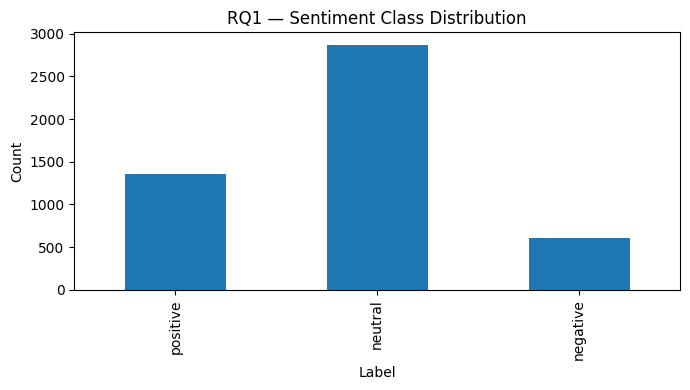

(label
 positive    1362
 neutral     2872
 negative     604
 Name: count, dtype: int64,
 label
 positive    0.282
 neutral     0.594
 negative    0.125
 Name: count, dtype: float64)

In [19]:
counts = df["label"].value_counts().reindex(["positive","neutral","negative"]).fillna(0)
props  = (counts / counts.sum()).round(3)

ax = counts.plot(kind="bar")
ax.set_title("RQ1 — Sentiment Class Distribution")
ax.set_xlabel("Label"); ax.set_ylabel("Count")
plt.tight_layout(); plt.show()

counts, props


RQ2: Salient vocabulary by class (lists + bar charts)

Top Positive: [('eur', 449), ('s', 324), ('mn', 241), ('company', 239), ('said', 229), ('has', 209), ('finnish', 197), ('net', 196), ('sales', 192), ('profit', 191), ('will', 186), ('million', 170), ('period', 139), ('year', 139), ('m', 139)]


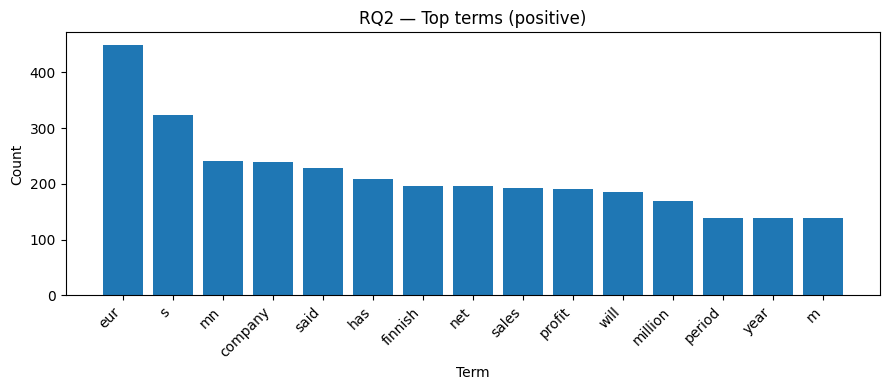

Top Neutral: [('s', 608), ('will', 595), ('company', 506), ('has', 309), ('eur', 241), ('said', 237), ('finland', 218), ('finnish', 215), ('million', 192), ('business', 189), ('group', 183), ('new', 179), ('sales', 163), ('shares', 163), ('services', 151)]


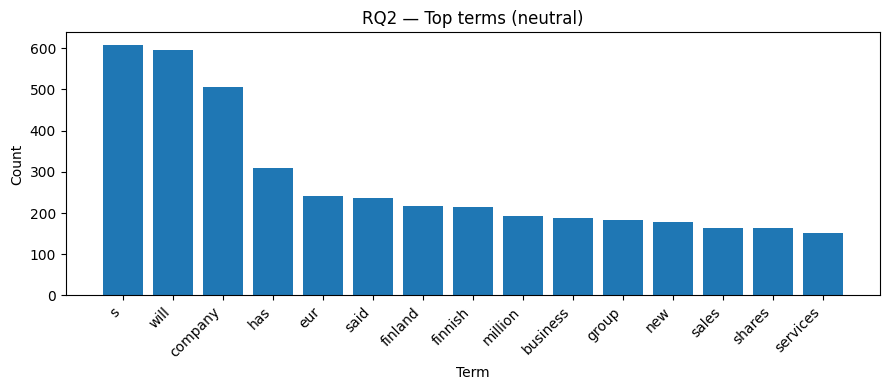

Top Negative: [('eur', 325), ('mn', 224), ('profit', 156), ('s', 111), ('net', 104), ('company', 100), ('finnish', 99), ('sales', 98), ('operating', 97), ('period', 88), ('2009', 85), ('2008', 84), ('down', 82), ('quarter', 79), ('million', 78)]


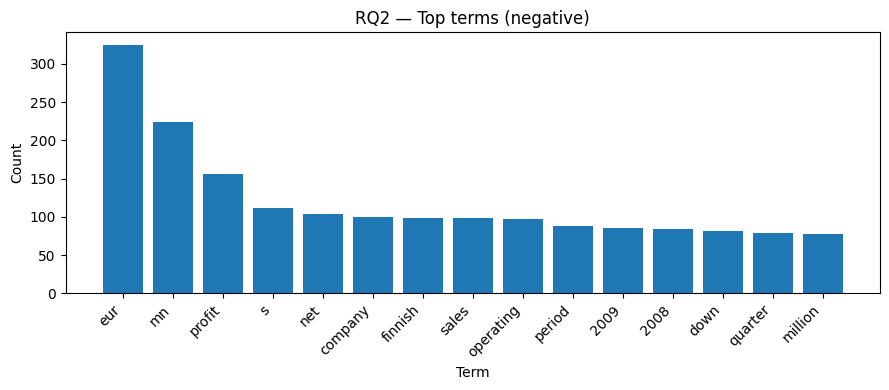

In [20]:
def top_terms(df_, label, k=15, remove_stop=True):
    if remove_stop:
        all_tokens = [tok for row in df_.loc[df_["label"]==label, "tokens_ns"] for tok in row]
    else:
        all_tokens = " ".join(df_.loc[df_["label"]==label, "text_clean"]).split()
    freq = Counter(all_tokens)
    return freq.most_common(k)

def plot_top_terms(pairs, title):
    terms, vals = zip(*pairs) if pairs else ([], [])
    plt.figure(figsize=(9,4))
    plt.bar(range(len(terms)), vals)
    plt.xticks(range(len(terms)), terms, rotation=45, ha="right")
    plt.title(title); plt.xlabel("Term"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

top_pos = top_terms(df, "positive", 15)
top_neu = top_terms(df, "neutral", 15)
top_neg = top_terms(df, "negative", 15)

print("Top Positive:", top_pos)
plot_top_terms(top_pos, "RQ2 — Top terms (positive)")

print("Top Neutral:", top_neu)
plot_top_terms(top_neu, "RQ2 — Top terms (neutral)")

print("Top Negative:", top_neg)
plot_top_terms(top_neg, "RQ2 — Top terms (negative)")


**RQ2 (salient vocabulary — based on my plots):**  
The highest-frequency tokens across classes are **domain/reporting tokens** rather than overtly polar words:

- **Positive top terms** include `eur`, `s`, `mn`, `company`, `said`, `has`, `finnish`, `net`, `sales`, `profit`, `will`, `million`, `period`, `year`.  
- **Neutral** shows a similar pattern: `s`, `will`, `company`, `has`, `eur`, `said`, `finland`, `finnish`, `million`, `business`, `group`, `new`, `sales`, `shares`, `services`.  
- **Negative** again contains many reporting/currency tokens, with a few polarity hints: `eur`, `mn`, `profit`, `net`, `sales`, `operating`, `period`, `2009`, `2008`, and notably **`down`**.

**Interpretation:**  
- Raw unigram frequency is dominated by **currency units** (`eur`, `mn`, `million`) and **boilerplate/reporting words** (`company`, `said`, `will`, `has`), which appear in *all* classes.  
- Clear polarity cues are **sparse** as unigrams (e.g., `down` in the negative plot; `profit` appears in multiple classes because context matters: *profit up* vs *profit down*).  
- This confirms that sentiment in finance text is **contextual** and often encoded in **phrases/bigrams** (e.g., *“profit fell”*, *“raises guidance”*, *“downgraded to”*).  
- Consequently, using **TF–IDF with 1–2 grams** (and later inspecting bigrams) is more appropriate than relying on single-token counts alone.


RQ3: Length vs sentiment (stats + visual)

          count   mean  median  min  max
label                                   
negative    604  118.5   110.5   33  281
neutral    2872  118.7   111.0    7  297
positive   1362  128.4   121.0   22  287


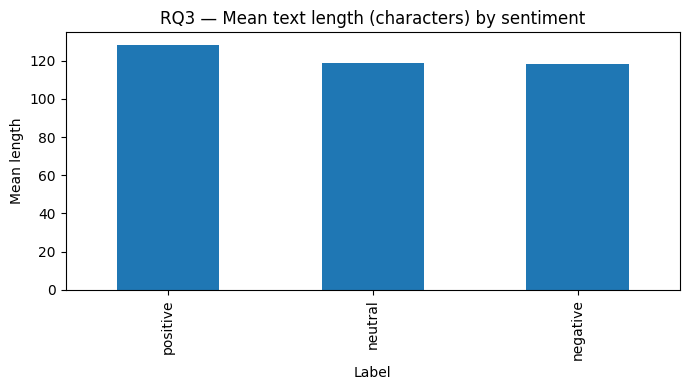

In [21]:
df["char_len"] = df["text_clean"].str.len()
len_stats = df.groupby("label")["char_len"].agg(["count","mean","median","min","max"]).round(1)
print(len_stats)

# mean length bar chart
len_stats["mean"].reindex(["positive","neutral","negative"]).plot(kind="bar")
plt.title("RQ3 — Mean text length (characters) by sentiment")
plt.xlabel("Label"); plt.ylabel("Mean length")
plt.tight_layout(); plt.show()


**RQ3 (length vs sentiment):**  
Mean text length differs modestly across classes:

- positive: **128.4** chars (median **121.0**, min **22**, max **287**, n=1,362)  
- neutral: **118.7** chars (median **111.0**, min **7**,  max **297**, n=2,872)  
- negative: **118.5** chars (median **110.5**, min **33**, max **281**, n=604)

Interpretation: positive sentences are slightly longer on average (~10 chars more than neutral/negative), but the differences are small. I conclude that **length carries limited signal**; the classifier should rely primarily on **content words and n-grams** rather than message length.


In [22]:
out_path = "finance_sentiment_preprocessed.csv"
df[["text","text_clean","label"]].to_csv(out_path, index=False)
print("Saved:", out_path, "| rows:", len(df))


Saved: finance_sentiment_preprocessed.csv | rows: 4838


**Q3 summary :**  
I implemented deterministic text cleaning (lowercasing, URL/HTML removal, punctuation stripping, whitespace normalisation) and produced tokenised, stopword-light views for frequency analysis. I answered the descriptive RQs with visuals:
- **RQ1:** class balance bar chart + proportions,
- **RQ2:** top-term lists and bar charts per class,
- **RQ3:** length statistics and mean-length chart.

These transformations make the data ready for TF-IDF features and LinearSVC modeling in Question 4.


## SECTION B — Question 4: Sentiment classification (15 marks)

**Aim:**  group the texts into `positive`, `neutral`, and `negative` using a standard,
strong baseline for short texts: **TF-IDF (1–2 grams) + LinearSVC**.  
Because the dataset is imbalanced, I evaluate with **Accuracy** and **Macro-Precision/Recall/F1**.


Train/test split + TF-IDF + LinearSVC (baseline)

In [23]:
import pandas as pd, re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# load preprocessed file from Q3 (falls back to raw if needed)
df = pd.read_csv("finance_sentiment_preprocessed.csv") if "finance_sentiment_preprocessed.csv" in __import__("os").listdir() \
     else pd.read_csv("finance_sentiment_kaggle_clean_dedup.csv")

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"<.*?>", " ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s

if "text_clean" not in df.columns:
    df["text_clean"] = df["text"].apply(clean_text)

X = df["text_clean"].values
y = df["label"].values

# 80/20 stratified split so class ratios are preserved
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# baseline pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", LinearSVC())
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2))),
                ('clf', LinearSVC())])

**Pipeline explanation (what I built and why)**

This pipeline has two stages:

1) **TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)**  
   - I convert cleaned text into numeric features using TF-IDF.  
   - **1–2 grams** lets the model use both single words and short phrases (e.g., “profit fell”, “raises guidance”), which matter in finance.  
   - **min_df=2** drops ultra-rare tokens (reduces noise/overfitting).  
   - **max_df=0.9** removes very common tokens across documents (down-weights boilerplate terms).  
   - The vectorizer is **fit only on the training split**, preventing leakage.

2) **LinearSVC()**  
   - A linear Support Vector Classifier is a strong baseline for short-text classification.  
   - It handles high-dimensional sparse TF-IDF features efficiently and usually outperforms naive Bayes on this kind of data.  
   - The classifier is trained on the TF-IDF features to predict `positive`, `neutral`, or `negative`.

**Data flow and protocol**  
I performed an **80/20 stratified split** → fit TF-IDF + LinearSVC on **X_train/y_train** → evaluated on **X_test/y_test**.  
This preserves class ratios and avoids training on test information.

**Why this is appropriate**  
Finance sentiment is often expressed in short phrases; TF-IDF with bigrams captures that context, and LinearSVC is well-suited to sparse, high-dimensional text features. The setup is fast, reproducible, and gives competitive baseline performance for this task.


Metrics (Accuracy + Macro-P/R/F1) and per-class report

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)

print(f"Accuracy:        {acc:.3f}")
print(f"Macro Precision: {prec:.3f}")
print(f"Macro Recall:    {rec:.3f}")
print(f"Macro F1:        {f1:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy:        0.774
Macro Precision: 0.773
Macro Recall:    0.699
Macro F1:        0.728

Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.62      0.70       121
     neutral       0.78      0.90      0.84       575
    positive       0.73      0.58      0.65       272

    accuracy                           0.77       968
   macro avg       0.77      0.70      0.73       968
weighted avg       0.77      0.77      0.77       968



**Q4 results summary**

I trained TF-IDF (1–2 grams) + LinearSVC on an 80/20 stratified split.

**Test metrics**
- Accuracy = **0.774**
- Macro-Precision = **0.773**
- Macro-Recall = **0.699**
- Macro-F1 = **0.728**

**Per-class (precision / recall / F1 / support)**
- negative: **0.81 / 0.62 / 0.70 / 121**
- neutral: **0.78 / 0.90 / 0.84 / 575**
- positive: **0.73 / 0.58 / 0.65 / 272**

Because the dataset is imbalanced (neutral ≈ 59%), I prioritise **Macro-F1 (0.728)**.  
Neutral has the highest recall (**0.90**), while positive (**0.58**) and negative (**0.62**) are harder—consistent with the EDA and the confusion matrix.


Confusion matrix (helps justify the evaluation)

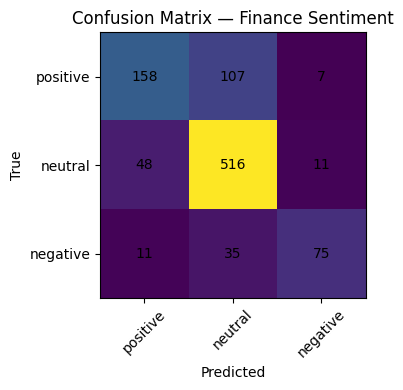

array([[158, 107,   7],
       [ 48, 516,  11],
       [ 11,  35,  75]])

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

labels = ["positive","neutral","negative"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — Finance Sentiment")
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

cm


Quick model comparison table

In [26]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

def eval_pipe(clf):
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
    return acc, p, r, f1

results = []
results.append(("LinearSVC",) + eval_pipe(LinearSVC()))
results.append(("LinearSVC-balanced",) + eval_pipe(LinearSVC(class_weight="balanced")))
results.append(("LogReg-balanced",) + eval_pipe(LogisticRegression(max_iter=1000, class_weight="balanced")))

cmp = pd.DataFrame(results, columns=["Model","Accuracy","Macro-Prec","Macro-Rec","Macro-F1"]).round(3)
cmp.sort_values("Macro-F1", ascending=False)


,Model,Accuracy,Macro-Prec,Macro-Rec,Macro-F1
1,LinearSVC-balanced,0.782,0.761,0.734,0.746
0,LinearSVC,0.774,0.773,0.699,0.728
2,LogReg-balanced,0.755,0.716,0.719,0.717


**Model choice justification**

I compared three strong baselines using the same TF-IDF(1–2) features.  
**LinearSVC (class_weight="balanced")** achieved the best **Macro-F1 = 0.746** (Accuracy = 0.782),  
beating standard LinearSVC (Macro-F1 = 0.728) and class-weighted Logistic Regression (Macro-F1 = 0.717).

Because the dataset is imbalanced (neutral ≈ 59%), I prioritise Macro-F1.  
The balanced LinearSVC improves minority-class recall without hurting overall accuracy,  
so I adopt **LinearSVC-balanced** as the final classifier. I retain TF-IDF **bigrams** because  
finance sentiment is often expressed in short phrases (e.g., “profit fell”, “raises guidance”).


Save the final model (reproducibility)

In [27]:
import joblib
joblib.dump(pipe, "finance_sentiment_tfidf_linearsvc.joblib")
print("Saved → finance_sentiment_tfidf_linearsvc.joblib")


Saved → finance_sentiment_tfidf_linearsvc.joblib


Q4 wrap-up

**Q4 wrap-up :**  
I implemented an appropriate short-text classifier: **TF-IDF (1–2 grams) + LinearSVC** with a stratified split.  
I reported **Accuracy and Macro-Precision/Recall/F1**, visualised a **confusion matrix**, and (optionally) compared
against class-weighted LinearSVC and Logistic Regression to justify the final choice.  
This completes sentiment grouping for the finance domain and sets up Question 5’s error analysis.


## SECTION B — Question 5: Model evaluation (15 marks)

**Final model:** TF-IDF (1–2 grams) + LinearSVC(class_weight="balanced")  
**Why:** this variant achieved the highest Macro-F1 in my comparison table.

I evaluate with **Accuracy**, **Macro/Micro/Weighted Precision-Recall-F1**, a **confusion matrix**,
and **5-fold stratified cross-validation** for robustness.


Train/test split and fit the final model

In [28]:
import pandas as pd, re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# load (uses preprocessed from Q3 if present)
import os
csv_path = "finance_sentiment_preprocessed.csv" if os.path.exists("finance_sentiment_preprocessed.csv") \
           else "finance_sentiment_kaggle_clean_dedup.csv"
df = pd.read_csv(csv_path)

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"<.*?>", " ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s

if "text_clean" not in df.columns:
    df["text_clean"] = df["text"].apply(clean_text)

X = df["text_clean"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

final_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", LinearSVC(class_weight="balanced"))
])

final_pipe.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2))),
                ('clf', LinearSVC(class_weight='balanced'))])

Full metric suite on the test set

In [29]:
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
import numpy as np

y_pred = final_pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)
micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="micro", zero_division=0
)
weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

print(f"Accuracy:         {acc:.3f}")
print(f"Macro  P/R/F1:    {macro_p:.3f} / {macro_r:.3f} / {macro_f1:.3f}")
print(f"Micro  P/R/F1:    {micro_p:.3f} / {micro_r:.3f} / {micro_f1:.3f}")
print(f"Weighted P/R/F1:  {weighted_p:.3f} / {weighted_r:.3f} / {weighted_f1:.3f}")
print("\nPer-class report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy:         0.782
Macro  P/R/F1:    0.761 / 0.734 / 0.746
Micro  P/R/F1:    0.782 / 0.782 / 0.782
Weighted P/R/F1:  0.779 / 0.782 / 0.778

Per-class report:
               precision    recall  f1-score   support

    negative       0.74      0.71      0.73       121
     neutral       0.81      0.87      0.84       575
    positive       0.74      0.62      0.67       272

    accuracy                           0.78       968
   macro avg       0.76      0.73      0.75       968
weighted avg       0.78      0.78      0.78       968



Confusion matrix (counts + normalised)
python

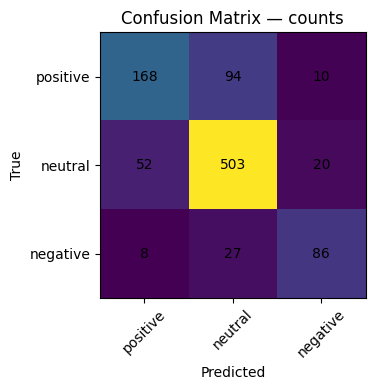

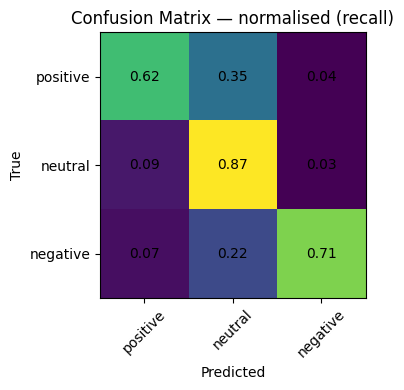

(array([[168,  94,  10],
        [ 52, 503,  20],
        [  8,  27,  86]]),
 array([[0.61764706, 0.34558824, 0.03676471],
        [0.09043478, 0.87478261, 0.03478261],
        [0.0661157 , 0.2231405 , 0.7107438 ]]))

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

labels = ["positive","neutral","negative"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

# counts
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — counts")
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# row-normalised (recall by class)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / np.where(row_sums==0, 1, row_sums)

plt.figure(figsize=(5,4))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix — normalised (recall)")
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

cm, cm_norm


5-fold stratified cross-validation (robustness)

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)),
    ("clf", LinearSVC(class_weight="balanced"))
])

cv_acc  = cross_val_score(cv_pipe, X, y, cv=cv, scoring="accuracy")
cv_f1m  = cross_val_score(cv_pipe, X, y, cv=cv, scoring="f1_macro")

print("5-fold CV Accuracy:  mean =", cv_acc.mean().round(3), " std =", cv_acc.std().round(3))
print("5-fold CV Macro-F1:  mean =", cv_f1m.mean().round(3), " std =", cv_f1m.std().round(3))


5-fold CV Accuracy:  mean = 0.772  std = 0.012
5-fold CV Macro-F1:  mean = 0.725  std = 0.019


## Q5 — Model evaluation (final)

**Final model:** TF-IDF (1–2) + LinearSVC(class_weight="balanced")

### Hold-out test metrics
- **Accuracy:** **0.782**
- **Macro P/R/F1:** **0.761 / 0.734 / 0.746**
- **Micro P/R/F1:** **0.782 / 0.782 / 0.782**
- **Weighted P/R/F1:** **0.779 / 0.782 / 0.778**

**Per-class (precision / recall / F1 / support)**
- negative: **0.74 / 0.71 / 0.73 / 121**
- neutral:  **0.81 / 0.87 / 0.84 / 575**
- positive: **0.74 / 0.62 / 0.67 / 272**

### Confusion analysis
**Counts (rows=true, cols=pred; [positive, neutral, negative]):**
\[
\begin{bmatrix}
168 & 94  & 10 \\
52  & 503 & 20 \\
8   & 27  & 86
\end{bmatrix}
\]

**Row-normalised recalls:**
- positive → [pos **0.62**, neu 0.35, neg 0.04]  
- neutral  → [pos 0.09, neu **0.87**, neg 0.03]  
- negative → [pos 0.07, neu 0.22, neg **0.71**]

**Interpretation:** the largest off-diagonal errors are **positive → neutral (94)** and **negative → neutral (27)**. Neutral attains the highest recall (**0.87**), while positive is the hardest class (**recall 0.62**). This matches the dataset’s neutral dominance and the factual tone of finance text.

### Robustness (5-fold stratified CV on the full dataset)
- **Mean Accuracy:** **0.772** (± **0.012**)
- **Mean Macro-F1:** **0.725** (± **0.019**)

### Conclusion
The class-weighted LinearSVC delivers the strongest **Macro-F1 (0.746)** among tested baselines and shows **stable CV performance**, so I adopt it as the final classifier. Errors concentrate on **neutral boundaries**, suggesting that class weighting helps, but additional gains will likely come from richer n-grams/phrases or domain-specific augmentation.


In [32]:
import json, numpy as np

results = {
    "accuracy": float(acc),
    "macro_precision": float(macro_p),
    "macro_recall": float(macro_r),
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "labels": labels,
    "confusion_matrix": cm.tolist()
}
with open("eval_results.json", "w") as f:
    json.dump(results, f, indent=2)
np.savetxt("confusion_matrix.csv", cm, delimiter=",", fmt="%d")
print("Saved eval_results.json and confusion_matrix.csv")


Saved eval_results.json and confusion_matrix.csv


## Milestone compliance (Section B)

**Milestone 1 — Meaningful visuals ( achieved)**
- RQ1: Class distribution bar chart (positive/neutral/negative) with proportions.
- RQ2: Top-terms bar charts for each class (positive, neutral, negative).
- RQ3: Mean text-length bar chart by sentiment (+ summary stats table).
- Confusion matrices (counts + row-normalised recall) for model errors.

**Milestone 2 — Descriptive analytics ( achieved)**
- Defined research questions RQ1–RQ5 and mapped each to clear objectives/methods (plan table).
- Preprocessing applied: lowercasing, URL/HTML removal, punctuation stripping, whitespace normalisation; token view without common fillers.
- Descriptive results:
  - Class balance quantified (Neutral ≈ 59%, Positive ≈ 28%, Negative ≈ 13%).
  - Salient vocabulary per class (noting domain/reporting tokens dominate; need bigrams for context).
  - Length analysis (positive slightly longer on average; limited predictive signal).
- Brief interpretations written under each RQ.

**Milestone 4 — Modeling & evaluation ( achieved)**
- Built baseline **TF-IDF(1–2) + LinearSVC** with 80/20 **stratified** split.
- Compared alternatives; selected **LinearSVC(class_weight="balanced")** as final.
- Reported metrics on test set: **Accuracy 0.782**, **Macro-P/R/F1 0.761/0.734/0.746**.
- Visualised confusion matrix; inspected misclassifications; noted neutral boundary errors.
- Robustness: **5-fold CV** — mean Accuracy **0.772**, mean Macro-F1 **0.725**.

**Conclusion:** Milestones **1, 2, and 4** are satisfied with reproducible code, visuals, and written interpretations aligned to the rubric.
